In [143]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn 
import numpy as np
import shutil
import torch
import os

## Setup directory

In [47]:
# setup directory
dir_path = './data/sea_animal/'
os.makedirs(os.path.join(dir_path,'train'), exist_ok=True)
os.makedirs(os.path.join(dir_path,'val'), exist_ok=True)
os.makedirs(os.path.join(dir_path,'test'), exist_ok=True)

In [48]:
class_names = os.listdir(dir_path)
class_names.remove('train')
class_names.remove('val')
class_names.remove('test')

In [67]:
for class_ in class_names :
    if not os.path.exists(os.path.join(dir_path, 'train', class_)) :
        full_path = os.path.join(dir_path, class_)
        images_path = [os.path.join(dir_path, class_, name) for name in os.listdir(full_path)]
        num_image = len(images_path)
        train_size = int(num_image * 0.70)
        val_size = int(num_image * 0.15)
        train_path = images_path[:train_size]
        val_path = images_path[train_size:train_size+val_size]
        test_path = images_path[train_size+val_size:]
        
        # create main folder
        train_des = os.path.join(dir_path, 'train', class_)
        val_des = os.path.join(dir_path, 'val', class_)
        test_des = os.path.join(dir_path, 'test', class_)
        for des in [train_des, val_des, test_des] :
            os.makedirs(des, exist_ok=True)
        
        # move images to train val test folder
        for image in train_path :
            shutil.move(image, train_des)
        for image in val_path :
            shutil.move(image, val_des)
        for image in test_path :
            shutil.move(image, test_des)

## Images to tensor

In [70]:
# setup train val test path
train_path = os.path.join(dir_path, 'train')
val_path = os.path.join(dir_path, 'val')
test_path = os.path.join(dir_path, 'test')

In [75]:
# transform images to tensor
train_transformer = transforms.Compose([ 
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
val_test_transformer = transforms.Compose([ 
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_images = datasets.ImageFolder(root=train_path, transform=train_transformer, target_transform=None)
val_images = datasets.ImageFolder(root=val_path, transform=val_test_transformer, target_transform=None)
test_images = datasets.ImageFolder(root=test_path, transform=val_test_transformer, target_transform=None)

len(train_images), len(val_images), len(test_images)

(8212, 1752, 1778)

In [74]:
class_names = train_images.classes

In [106]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_images, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
val_dataloader = DataLoader(dataset=val_images, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_images, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

In [107]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


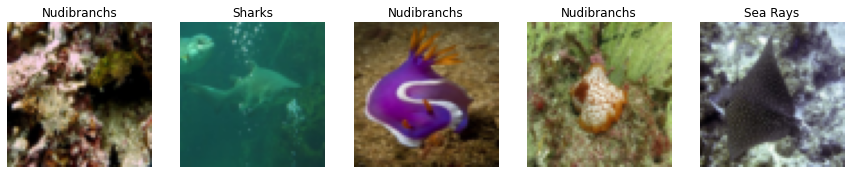

In [114]:
random_idx = np.random.permutation(BATCH_SIZE)
plt.figure(figsize=(15,30))
for sample_image in range(5) :
    idx = random_idx[sample_image]
    plt.subplot(1,5,sample_image+1)
    plt.imshow(img[idx].permute(1,2,0));
    plt.title(class_names[label[idx]])
    plt.axis('off')

## Create Model

In [139]:
class SeaAnimalModel(nn.Module) :
    def __init__(self, no_channel, hidden_units, no_class ):
        super().__init__()
        
        self.conv2d_1 = nn.Conv2d(no_channel, hidden_units, kernel_size=(5,5), padding='valid')
        self.maxpool = nn.MaxPool2d((2,2))
        self.relu = nn.ReLU()
        self.conv2d_2 = nn.Conv2d(hidden_units, hidden_units, kernel_size=(3,3), padding='same')
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(hidden_units*15*15, no_class)
    
    def forward(self, x) :
        x = self.conv2d_1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2d_2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [140]:
modelTester = SeaAnimalModel(no_channel=3, hidden_units=8, no_class=3)
modelTester(img)[:5]

tensor([[ 0.0084,  0.0175, -0.0355],
        [ 0.0026,  0.0127, -0.0369],
        [-0.0017,  0.0285, -0.0492],
        [-0.0011,  0.0140, -0.0195],
        [ 0.0049,  0.0115, -0.0281]], grad_fn=<SliceBackward0>)

## Train Model

In [149]:
def train_step(model, dataloader, loss_fn, optimizer) :
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (x,y) in enumerate(dataloader) :
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # take avg for each batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [150]:
def test_step(model, dataloader, loss_fn) :
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode() :
        for batch, (x,y) in enumerate(dataloader) :
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # take avg for each batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc        

In [151]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs, model_name) :
    
    best_loss = np.Infinity 
    results = {
        'train_loss' : [],
        'train_acc' : [],
        'val_loss' : [],
        'val_acc' : []
    }

    for epoch in tqdm(range(epochs)) :
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        val_loss, val_acc = test_step(model, val_dataloader, loss_fn)

        if val_loss < best_loss :
            best_loss = val_loss
            save_path = f'./save_model/model_checkpoint/best_{model_name}.pth'
            torch.save(model.state_dict(), save_path)
            print(f' -- save model to : {save_path}')
        
        print(
            f'Epoch : {epoch+1} | '
            f'train_acc : {train_acc:.4f} |'
            f'train_loss : {train_loss:.4f} |'
            f'val_acc : {val_acc:.4f} |'
            f'val_loss : {val_loss:.4f} '
        )
    
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
    
    results['epochs'] = [ i+1 for i in range(epochs)]
    return results

In [152]:
from timeit import default_timer as timer

NUM_EPOCHS = 5
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

modelV1 = SeaAnimalModel(no_channel=3, hidden_units=8, no_class=len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.01)

start_time = timer()
modelV1_result = train_model(modelV1, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:42<02:49, 42.38s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 1 | train_acc : 0.1656 |train_loss : 2.7804 |val_acc : 0.2061 |val_loss : 2.7070 


 40%|████      | 2/5 [01:14<01:48, 36.21s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 2 | train_acc : 0.2248 |train_loss : 2.5673 |val_acc : 0.2205 |val_loss : 2.5751 


 60%|██████    | 3/5 [01:45<01:07, 33.95s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 3 | train_acc : 0.2589 |train_loss : 2.3907 |val_acc : 0.2443 |val_loss : 2.5133 


 80%|████████  | 4/5 [02:16<00:32, 32.69s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 4 | train_acc : 0.2752 |train_loss : 2.3222 |val_acc : 0.2568 |val_loss : 2.4820 


100%|██████████| 5/5 [02:46<00:00, 33.38s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 5 | train_acc : 0.2955 |train_loss : 2.2719 |val_acc : 0.2703 |val_loss : 2.4003 
Total training time: 166.918 seconds


Continue train | adjust some parameters

In [153]:
NUM_EPOCHS = 5
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.02)

start_time = timer()
modelV1_result = train_model(modelV1, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:32<02:09, 32.47s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 1 | train_acc : 0.2872 |train_loss : 2.2930 |val_acc : 0.2617 |val_loss : 2.4381 


 40%|████      | 2/5 [01:05<01:38, 32.96s/it]

Epoch : 2 | train_acc : 0.3017 |train_loss : 2.2455 |val_acc : 0.2265 |val_loss : 2.4625 


 60%|██████    | 3/5 [01:36<01:04, 32.08s/it]

Epoch : 3 | train_acc : 0.3160 |train_loss : 2.2211 |val_acc : 0.2801 |val_loss : 2.4827 


 80%|████████  | 4/5 [02:07<00:31, 31.71s/it]

Epoch : 4 | train_acc : 0.3279 |train_loss : 2.1925 |val_acc : 0.2345 |val_loss : 2.4604 


100%|██████████| 5/5 [02:38<00:00, 31.71s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 5 | train_acc : 0.3358 |train_loss : 2.1595 |val_acc : 0.2748 |val_loss : 2.3405 
Total training time: 158.561 seconds


In [154]:
NUM_EPOCHS = 5
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.005)

start_time = timer()
modelV1_result = train_model(modelV1, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel_lr0.005')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:33<02:15, 33.83s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.005.pth
Epoch : 1 | train_acc : 0.3651 |train_loss : 2.0486 |val_acc : 0.3063 |val_loss : 2.2365 


 40%|████      | 2/5 [01:05<01:37, 32.36s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.005.pth
Epoch : 2 | train_acc : 0.3719 |train_loss : 2.0229 |val_acc : 0.3087 |val_loss : 2.2211 


 60%|██████    | 3/5 [01:37<01:04, 32.22s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.005.pth
Epoch : 3 | train_acc : 0.3776 |train_loss : 2.0108 |val_acc : 0.3364 |val_loss : 2.1839 


 80%|████████  | 4/5 [02:08<00:31, 31.75s/it]

Epoch : 4 | train_acc : 0.3790 |train_loss : 1.9948 |val_acc : 0.3220 |val_loss : 2.2224 


100%|██████████| 5/5 [02:39<00:00, 32.00s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.005.pth
Epoch : 5 | train_acc : 0.3812 |train_loss : 1.9878 |val_acc : 0.3413 |val_loss : 2.1624 
Total training time: 159.987 seconds


In [155]:
NUM_EPOCHS = 10
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.004)

start_time = timer()
modelV1_result = train_model(modelV1, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel_lr0.004')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:34<05:09, 34.36s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 1 | train_acc : 0.3901 |train_loss : 1.9731 |val_acc : 0.3316 |val_loss : 2.1968 


 20%|██        | 2/10 [01:05<04:21, 32.69s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 2 | train_acc : 0.3894 |train_loss : 1.9627 |val_acc : 0.3339 |val_loss : 2.1670 


 30%|███       | 3/10 [01:44<04:06, 35.25s/it]

Epoch : 3 | train_acc : 0.3962 |train_loss : 1.9557 |val_acc : 0.3472 |val_loss : 2.1672 


 40%|████      | 4/10 [02:21<03:36, 36.11s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 4 | train_acc : 0.3942 |train_loss : 1.9479 |val_acc : 0.3559 |val_loss : 2.1398 


 50%|█████     | 5/10 [02:59<03:02, 36.59s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 5 | train_acc : 0.4006 |train_loss : 1.9379 |val_acc : 0.3547 |val_loss : 2.1384 


 60%|██████    | 6/10 [03:32<02:22, 35.51s/it]

Epoch : 6 | train_acc : 0.4000 |train_loss : 1.9338 |val_acc : 0.3307 |val_loss : 2.2200 


 70%|███████   | 7/10 [04:06<01:44, 34.99s/it]

Epoch : 7 | train_acc : 0.4002 |train_loss : 1.9221 |val_acc : 0.3335 |val_loss : 2.1472 


 80%|████████  | 8/10 [04:39<01:08, 34.24s/it]

Epoch : 8 | train_acc : 0.4067 |train_loss : 1.9098 |val_acc : 0.3483 |val_loss : 2.1445 


 90%|█████████ | 9/10 [05:10<00:33, 33.49s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 9 | train_acc : 0.4070 |train_loss : 1.9046 |val_acc : 0.3636 |val_loss : 2.1152 


100%|██████████| 10/10 [05:42<00:00, 34.28s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 10 | train_acc : 0.4113 |train_loss : 1.8946 |val_acc : 0.3532 |val_loss : 2.1114 
Total training time: 342.833 seconds
